In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape
from keras.layers import Input
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash

Using TensorFlow backend.


# Args

In [2]:
num_class = 10
input_shape = (28, 28, 1)

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
x_train = x_train.reshape(-1, *input_shape).astype('float32') / 255
x_test = x_test.reshape(-1, *input_shape).astype('float32') / 255

y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

# Model

In [5]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=256, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=16, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(784, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 1152, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            1474560   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 6,804,224
Trainable params: 6,804,224
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model_training.compile(loss=[margin(), mean_squared_error],
                        loss_weights=[1, 0.0005],
                        optimizer=Adam(lr=1e-4),
                        metrics={'capsule': 'accuracy'})

In [8]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
hist = model_training.fit([x_train, y_train],
                            [y_train, x_train],
                            batch_size=32,
                            epochs=3,
                            validation_data=([x_test, y_test], [y_test, x_test]),
                            callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2003s 33ms/step - loss: 0.0296 - capsule_loss: 0.0295 - reconstruction_loss: 0.1532 - capsule_acc: 0.1854 - val_loss: 3.4809e-05 - val_capsule_loss: 7.9722e-07 - val_reconstruction_loss: 0.0680 - val_capsule_acc: 0.3427
Epoch 2/3
60000/60000 [==============================] - 2014s 34ms/step - loss: 3.3776e-05 - capsule_loss: 5.1918e-07 - reconstruction_loss: 0.0665 - capsule_acc: 0.4207 - val_loss: 3.3214e-05 - val_capsule_loss: 2.7969e-07 - val_reconstruction_loss: 0.0659 - val_capsule_acc: 0.5137
Epoch 3/3
60000/60000 [==============================] - 1893s 32ms/step - loss: 3.2592e-05 - capsule_loss: 1.4412e-07 - reconstruction_loss: 0.0649 - capsule_acc: 0.5582 - val_loss: 3.2140e-05 - val_capsule_loss: 6.7946e-08 - val_reconstruction_loss: 0.0641 - val_capsule_acc: 0.6356


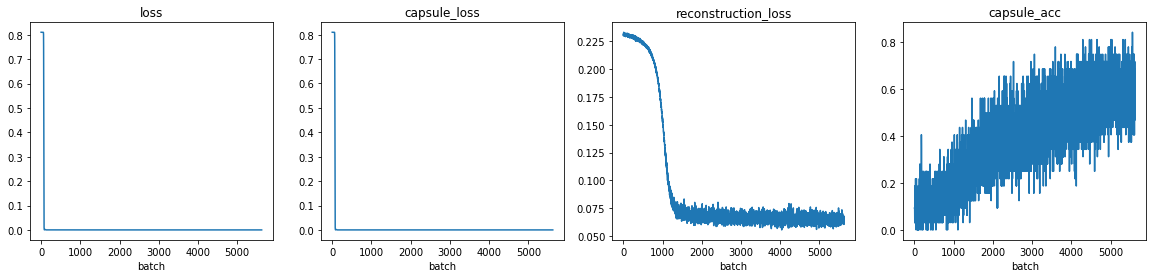

In [9]:
plotHistory(history.metrics)

# Visualization

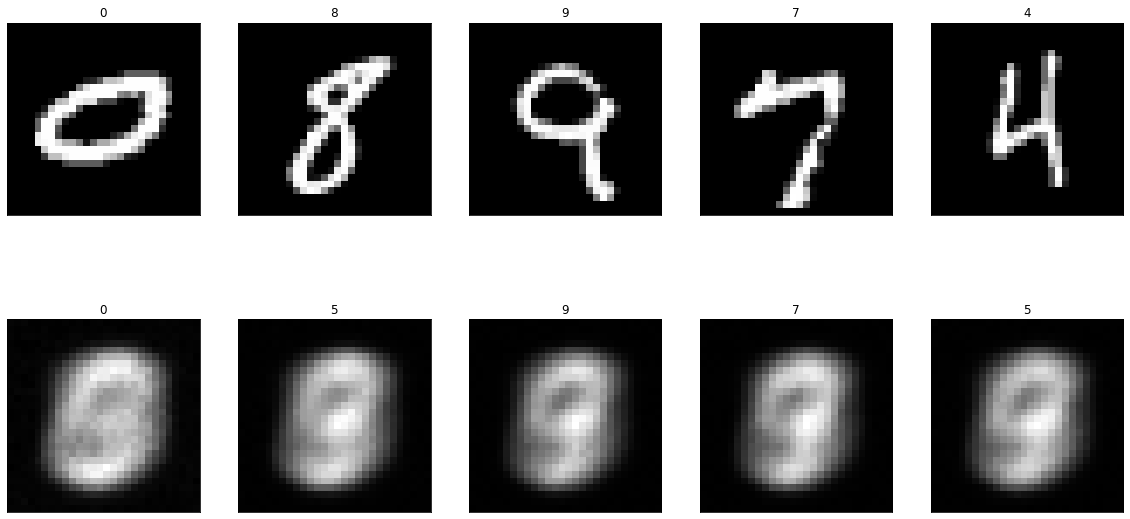

In [10]:
n_image = 5

display_index = np.random.choice(x_test.shape[0], n_image)
images = np.array([x_test[i] for i in display_index])
labels = np.array([y_test[i] for i in display_index])

classes, reconstructions = model_training.predict([images, labels])

labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)
images = images.reshape(-1, 28, 28)
reconstructions = reconstructions.reshape(-1, 28, 28)

visualization((images, labels), (reconstructions, predictions))